In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from utils import *

### A0: Define the Domain

In [2]:
# Define the coordinates for the polygon
x = [0, 0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 1, 1, 0.5, 0.5, 0.4, 0.4, 0]
y = [1, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 1, 1, 0.2, 0.2, 1, 1]

#### A.1 Sample the Domain

In [3]:
sampling_mode = 'grid'

if sampling_mode == 'at_random':
    sample_points, signed_distances = sample_domain(x, y, method='random', n_samples=500)       # Random sampling
else:
    sample_points, signed_distances = sample_domain(x, y, method='grid', grid_size=(32, 32))    # Grid sampling

#### A.2 Sample the Boundary

In [4]:
# Sample the boundary
n_boundary_samples = 1000

# Calculate the cumulative distance along the polygon
dist = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
dist = np.insert(dist, 0, 0) / dist[-1]

# Generate evenly spaced points along the total distance
t = np.linspace(0, 1, n_boundary_samples, endpoint=False)

# Interpolate to find the boundary points
boundary_x = np.interp(t, dist, x)
boundary_y = np.interp(t, dist, y)

In [5]:
# Prepare all data
boundary_points = np.column_stack((boundary_x, boundary_y))
boundary_sdf = np.zeros((n_boundary_samples, 1))

X = np.vstack((sample_points, boundary_points))
sdf_vals = np.vstack((signed_distances.reshape(-1, 1), boundary_sdf))

#### A3. Visualize

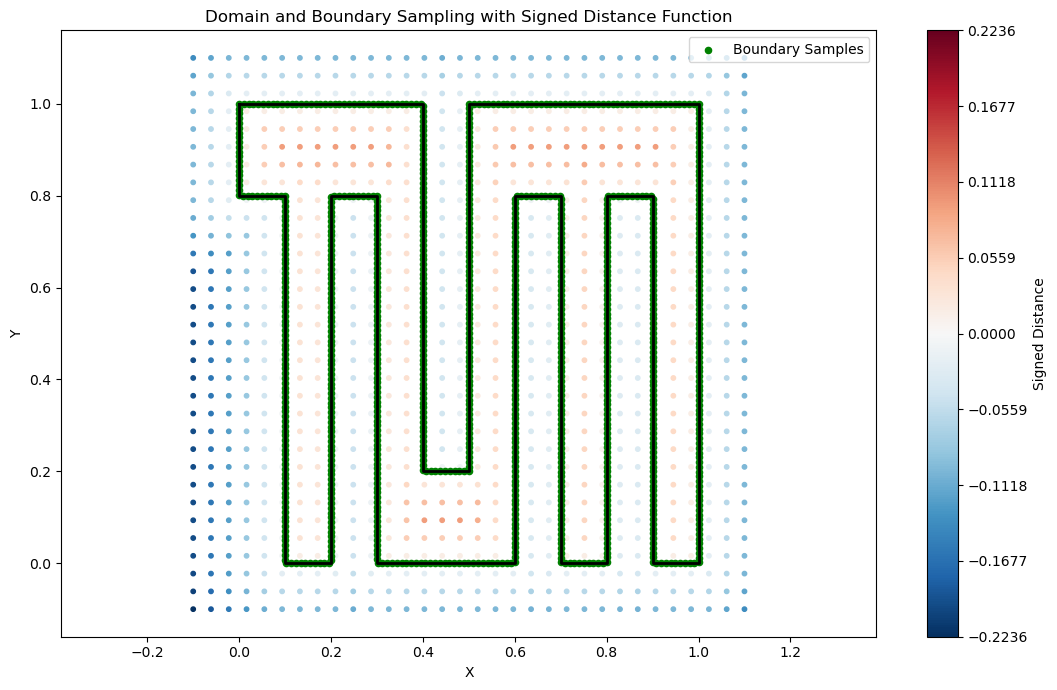

In [6]:
# Determine the maximum absolute value of the signed distances
max_abs_distance = np.max(np.abs(signed_distances))

# Visualize
plt.figure(figsize=(11, 7))

# Use vmin and vmax to set symmetric limits for the colormap
scatter = plt.scatter(sample_points[:, 0], sample_points[:, 1], c=signed_distances, cmap='RdBu_r', s=10, 
                      vmin=-max_abs_distance, vmax=max_abs_distance)

# Create a symmetric colorbar
cbar = plt.colorbar(scatter, label='Signed Distance')
cbar.set_ticks(np.linspace(-max_abs_distance, max_abs_distance, 9))

plt.plot(x, y, 'k-', linewidth=2)
plt.scatter(boundary_x, boundary_y, c='g', s=20, label='Boundary Samples')
plt.title('Domain and Boundary Sampling with Signed Distance Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

In [7]:
# Fourier feature mapping using TensorFlow operations
def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = tf.matmul(x, tf.transpose(B)) * (2.0 * np.pi)
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# Custom layer for Fourier features
class FourierFeatures(tf.keras.layers.Layer):
    def __init__(self, B=None):
        super(FourierFeatures, self).__init__()
        self.B = B

    def call(self, inputs):
        return input_mapping(inputs, self.B)

# Define the MLP model with Fourier features
layers = []
for _ in range(6):
    layers.append(tf.keras.layers.Dense(512, activation='relu'))

# Create B_dict with different Fourier feature mappings
mapping_size = 256

B_dict = {
    'none': None,
    'basic': np.eye(2, dtype=np.float32),  # Ensure dtype is float32
    'gauss_1': np.random.normal(size=(mapping_size, 2)).astype(np.float32) * 1.0,
    'gauss_10': np.random.normal(size=(mapping_size, 2)).astype(np.float32) * 10.0,
    'gauss_100': np.random.normal(size=(mapping_size, 2)).astype(np.float32) * 100.0,
}

B = B_dict['gauss_1']

# Define the neural network model
neural_SDF = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    FourierFeatures(B=B),       # Add Fourier features layer
    *layers,                    # Unpack the list of layers with dropout
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)    # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
neural_SDF.compile(optimizer=optimizer, loss='mae', metrics=['mse'])

# Define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=50,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7          # Lower bound on the learning rate
) 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=150,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

callbacks = [reduce_lr] #+ [early_stopping]

# Train the model with callbacks
history = neural_SDF.fit(X, sdf_vals, epochs=700, batch_size = np.floor(sdf_vals.shape[0]*.8).astype('int'), validation_split=0.4, callbacks=callbacks)


Epoch 1/700
1/1 [==============================] - 2s 2s/step - loss: 0.0861 - mse: 0.0114 - val_loss: 0.0422 - val_mse: 0.0029 - lr: 1.0000e-04
Epoch 2/700
1/1 [==============================] - 0s 95ms/step - loss: 0.0606 - mse: 0.0066 - val_loss: 0.1256 - val_mse: 0.0176 - lr: 1.0000e-04
Epoch 3/700
1/1 [==============================] - 0s 91ms/step - loss: 0.1131 - mse: 0.0154 - val_loss: 0.0691 - val_mse: 0.0061 - lr: 1.0000e-04
Epoch 4/700
1/1 [==============================] - 0s 85ms/step - loss: 0.0624 - mse: 0.0056 - val_loss: 0.0505 - val_mse: 0.0037 - lr: 1.0000e-04
Epoch 5/700
1/1 [==============================] - 0s 92ms/step - loss: 0.0617 - mse: 0.0054 - val_loss: 0.0662 - val_mse: 0.0057 - lr: 1.0000e-04
Epoch 6/700
1/1 [==============================] - 0s 95ms/step - loss: 0.0730 - mse: 0.0070 - val_loss: 0.0361 - val_mse: 0.0020 - lr: 1.0000e-04
Epoch 7/700
1/1 [==============================] - 0s 95ms/step - loss: 0.0400 - mse: 0.0025 - val_loss: 0.0360 - val_ms

In [ ]:
# Plot the training history
plt.figure(figsize=(10, 5))
plt.plot(np.array(history.history['loss']) / history.history['loss'][0], label='Training Loss')
plt.plot(np.array(history.history['val_loss']) / history.history['val_loss'][0], label='Validation Loss')
plt.title('Normalized Model Loss')
plt.ylabel('Normalized Loss')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')  # Use log scale for y-axis
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.savefig("Figures/SDF_training_MoE.png", dpi=300, bbox_inches='tight')
plt.show()

313/313 [==============================] - 1s 3ms/step


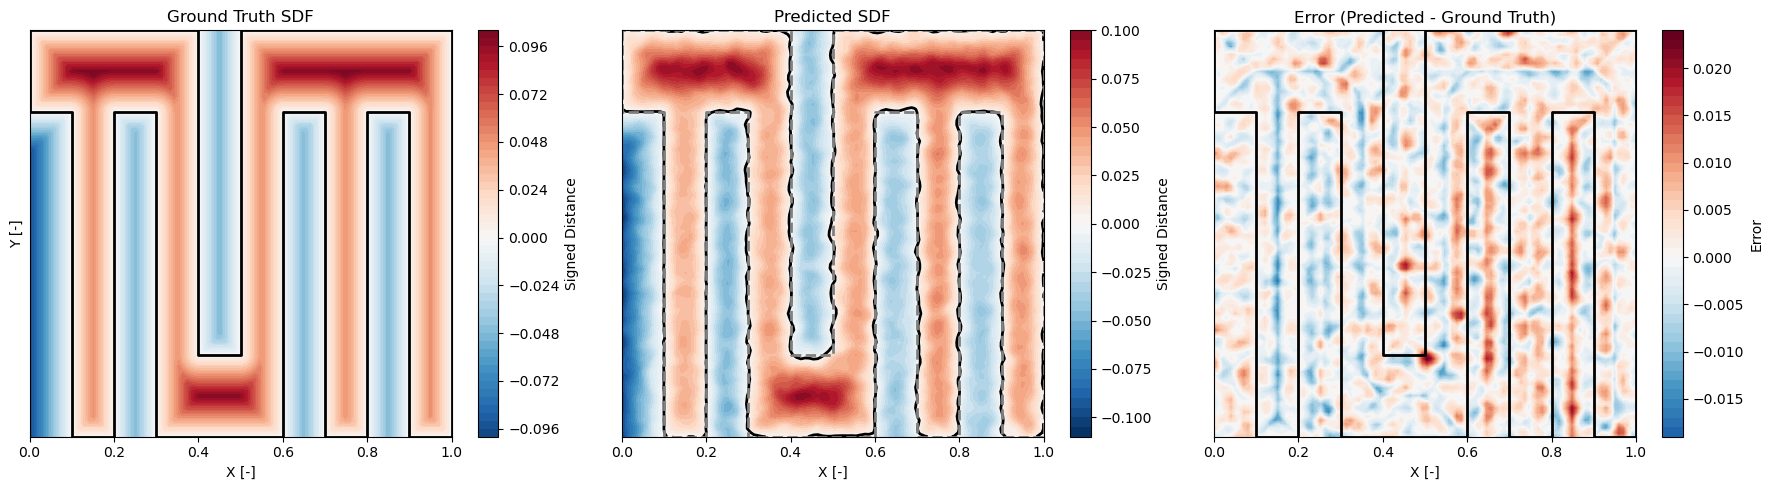

Mean Absolute Error: 0.003600
Max Absolute Error: 0.023210


In [8]:
# Convert x and y to numpy arrays if they're not already
x = np.array(x)
y = np.array(y)

# Generate a grid for visualization
x_grid, y_grid = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)
X_grid = np.column_stack((x_grid.ravel(), y_grid.ravel()))

# Predict SDF using the trained model
predicted_sdf = neural_SDF.predict(X_grid).reshape(x_grid.shape)

# Compute ground truth SDF for the grid
ground_truth_sdf = compute_signed_distance_vectorized(X_grid, x, y).reshape(x_grid.shape)

# Compute the error
error_sdf = predicted_sdf - ground_truth_sdf

# Determine the maximum absolute value of both SDFs and error for consistent color scaling
max_abs_sdf = max(np.max(np.abs(ground_truth_sdf)), np.max(np.abs(predicted_sdf)))
max_abs_error = np.max(np.abs(error_sdf))

# Visualize the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Ground Truth SDF
contour1 = ax1.contourf(x_grid, y_grid, ground_truth_sdf, levels=50, cmap='RdBu_r', vmin=-max_abs_sdf, vmax=max_abs_sdf)
fig.colorbar(contour1, ax=ax1, label='Signed Distance')
ax1.plot(np.append(x, x[0]), np.append(y, y[0]), 'k-', linewidth=2)
ax1.set_title('Ground Truth SDF')
ax1.set_xlabel('X [-]')
ax1.set_ylabel('Y [-]')

# Predicted SDF
contour2 = ax2.contourf(x_grid, y_grid, predicted_sdf, levels=50, cmap='RdBu_r', vmin=-max_abs_sdf, vmax=max_abs_sdf)
fig.colorbar(contour2, ax=ax2, label='Signed Distance')
ax2.contour(x_grid, y_grid, predicted_sdf, levels=[0], colors='black', linewidths=2)  # Zero set contour
ax2.plot(np.append(x, x[0]), np.append(y, y[0]), color='grey', linestyle='--', linewidth=2)
ax2.set_title('Predicted SDF')
ax2.set_xlabel('X [-]')

# Error Plot
contour3 = ax3.contourf(x_grid, y_grid, error_sdf, levels=50, cmap='RdBu_r', vmin=-max_abs_error, vmax=max_abs_error)
fig.colorbar(contour3, ax=ax3, label='Error')
ax3.plot(np.append(x, x[0]), np.append(y, y[0]), 'k-', linewidth=2)
ax3.set_title('Error (Predicted - Ground Truth)')
ax3.set_xlabel('X [-]')
ax3.set_yticks([])  # Remove Y-axis ticks from ax3

plt.tight_layout()
plt.savefig("Figures/NN_SDF_with_Error.png", dpi=300, bbox_inches='tight')
plt.show()

# Print some error statistics
mean_absolute_error = np.mean(np.abs(error_sdf))
max_absolute_error = np.max(np.abs(error_sdf))
print(f"Mean Absolute Error: {mean_absolute_error:.6f}")
print(f"Max Absolute Error: {max_absolute_error:.6f}")


In [9]:
# Save the entire model as a SavedModel
neural_SDF.save('models\my_sdf_model')

INFO:tensorflow:Assets written to: models\my_sdf_model\assets


INFO:tensorflow:Assets written to: models\my_sdf_model\assets
